# MPS using the deesse wrapper - multivariate simulations (II)

## Main points addressed:
- deesse simulations with a non-stationary training image
- how to deal with non-stationarity by using an auxiliary variable (bivariate simulations)

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os

# import package 'geone'
import geone as gn

In [2]:
# Show version of python and version of geone
import sys 
print(sys.version_info)
print('geone version: ' + gn.__version__)

sys.version_info(major=3, minor=10, micro=9, releaselevel='final', serial=0)
geone version: 1.1.11


## Non stationary training image (TI)
Read the univariate training image.

In [3]:
data_dir = 'data' # directory containing the training image file
ti = gn.img.readImageGslib(os.path.join(data_dir, 'ti3.gslib'))

Plot the image using the function `geone.imgplot.drawImage2D`. This image is clearly non-stationary: the density of "orange balls" depends on a vertical trend.

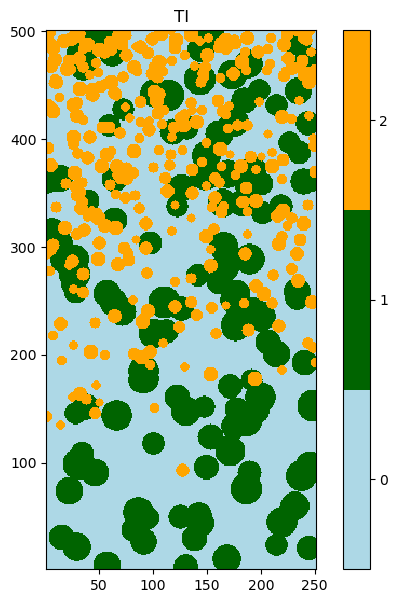

In [4]:
col = ['lightblue', 'darkgreen', 'orange']

plt.figure(figsize=(5,7))
gn.imgplot.drawImage2D(ti, categ=True, categCol=col, title='TI')
plt.show()

## Simulation grid
Define the simulation grid (number of cells in each direction, cell unit, origin).

In [5]:
nx, ny, nz = 300, 400, 1         # number of cells
sx, sy, sz = ti.sx, ti.sy, ti.sz # cell unit
ox, oy, oz = 0.0, 0.0, 0.0       # origin (corner of the "first" grid cell)

## Univariate simulation (not accounting for non-stationarity)

### Fill the input structure for deesse and launch deesse

In [6]:
deesse_input = gn.deesseinterface.DeesseInput(
    nx=nx, ny=ny, nz=nz,
    sx=sx, sy=sy, sz=sz,
    ox=ox, oy=oy, oz=oz,
    nv=1, varname='code',
    TI=ti,
    distanceType='categorical',
    nneighboringNode=24,
    distanceThreshold=0.02,
    maxScanFraction=0.15,
    npostProcessingPathMax=1,
    seed=444,
    nrealization=2)

# Run deesse
t1 = time.time() # start time
deesse_output = gn.deesseinterface.deesseRun_mp(deesse_input)
t2 = time.time() # end time
print(f'Elapsed time: {t2-t1:.2g} sec')

DeeSse running on 2 process(es)... [VERSION 3.2 / BUILD NUMBER 20230411 / OpenMP 9 thread(s)]
* checking out license OK.
* checking out license OK.
DeeSse run complete (all process(es))
Elapsed time: 3.4 sec


One observes on the results that the non-stationarity is uncontrolled: region with high density of "orange balls" can be found anywhere. 

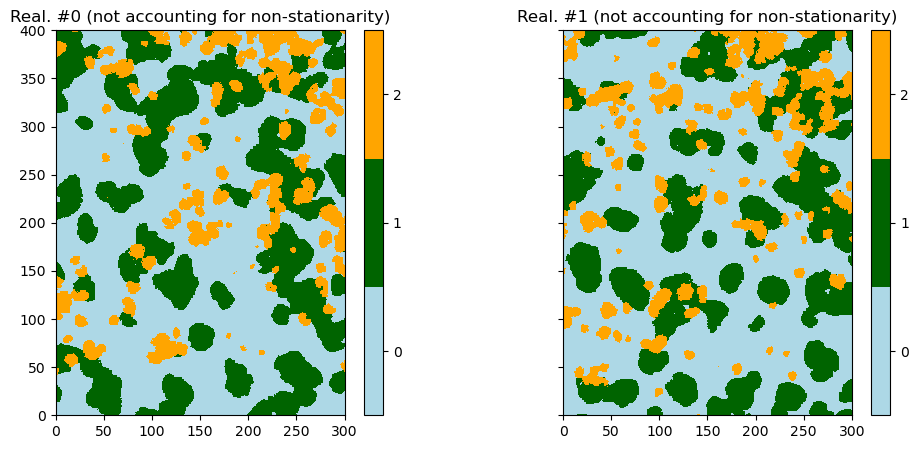

In [7]:
# Retrieve the results
sim = deesse_output['sim']

# Display
plt.subplots(1, 2, figsize=(12,5), sharey=True) # 1 x 2 sub-plots
for i in range(2):
    plt.subplot(1, 2, i+1) # select next sub-plot
    gn.imgplot.drawImage2D(sim[i], categ=True, categCol=col,
                           title=f'Real. #{i} (not accounting for non-stationarity)')
plt.show()

## Dealing with non-stationarity
To deal with the non-stationarity, the idea is to use an auxiliary variable to describe the non-stationarity in the TI. In this example, a simple vertical trend is sufficient.

### Define an auxiliary variable in the TI describing its non-stationarity

In [8]:
# xg, yg: coordinates of the centers of TI grid cell
xg = ti.x() # xg = ti.ox + 0.5*ti.sx + ti.sx*np.arange(ti.nx)
yg = ti.y() # yg = ti.oy + 0.5*ti.sy + ti.sy*np.arange(ti.ny)
xx, yy = np.meshgrid(xg, yg) # create meshgrid from the center of TI grid cells

# Define an auxiliary variable describing the trend (non stationarity)
aux_var = (yy - np.min(yy))/(np.max(yy) - np.min(yy)) # vertical trend
aux_var.shape
ti.insert_var(aux_var, varname='aux') # insert the new variable (index 0)

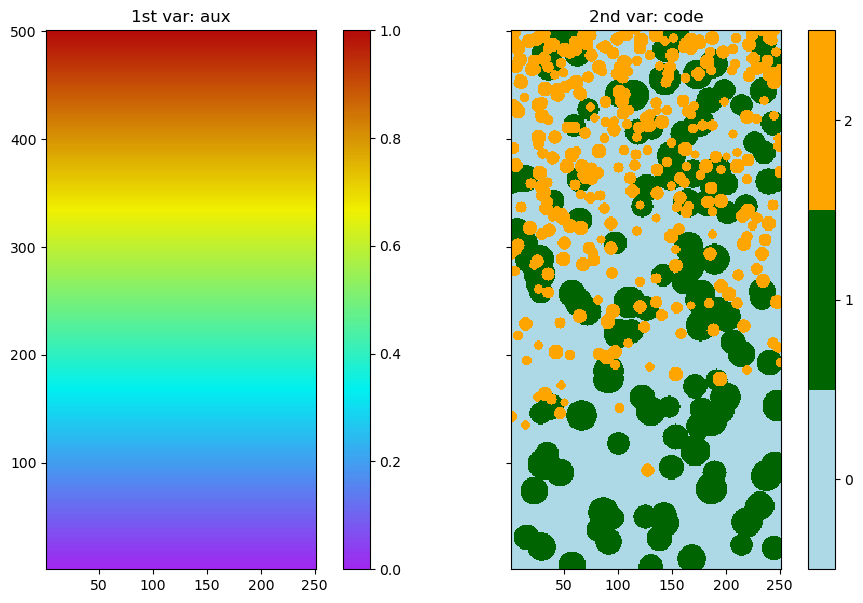

In [9]:
# Display
plt.subplots(1, 2, figsize=(11,7), sharey=True) # 1 x 2 sub-plots

plt.subplot(1,2,1)
gn.imgplot.drawImage2D(ti, iv=0, title=f'1st var: {ti.varname[0]}')

plt.subplot(1,2,2)
gn.imgplot.drawImage2D(ti, iv=1, categ=True, categCol=col, title=f'2nd var: {ti.varname[1]}')

plt.show()

## Bivariate simulation (accounting for non stationarity)

### Build an auxiliary variable in the simulation grid
An auxiliary variable is built on the simulation grid to control the non-stationarity. This auxiliary variable is of the same nature as the auxiliary variable on the TI (same range of values) and allows to describe which types of pattern for the original variable will be simulated in which regions of the simulation grid. In this example, patterns with high density of "orange balls" will be simulated where the auxiliary variable has high values (close to one).  

Below is a piece of python code to build an auxiliary variable on the simulation grid.

In [10]:
# xg, yg: coordinates of the centers of simulationg grid cell
xg = ox + 0.5*sx + sx*np.arange(nx)
yg = oy + 0.5*sy + sy*np.arange(ny)
xx, yy = np.meshgrid(xg, yg) # create meshgrid from the center of simulation grid cells

# Define an auxiliary variable describing (controlling) the trend (non stationarity) in the simulation grid
aux_var = np.sqrt((xx - ox)**2 + (yy - (oy+ny*sy))**2)
aux_var = 1.0 - (aux_var - np.min(aux_var))/(np.max(aux_var) - np.min(aux_var))

# Define a new "image" with this variable
im_aux = gn.img.Img(nx=nx, ny=ny, nz=nz,
                    sx=sx, sy=sy, sz=sz,
                    ox=ox, oy=oy, oz=oz,
                    nv=1, val=aux_var, varname='aux')

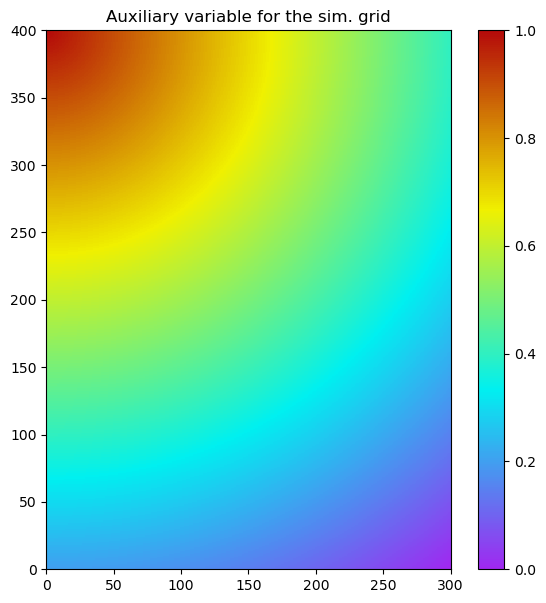

In [11]:
# Display
plt.figure(figsize=(7,7))
gn.imgplot.drawImage2D(im_aux, title='Auxiliary variable for the sim. grid')
plt.show()

### Fill the input structure for deesse and launch deesse
Then a bivariate simulation is done, with the auxiliary variable and the original (categorical variable). The auxiliary variable is *exhaustively known* on the simulation grid, and then it is set as hard data. It can be passed to deesse as an image (keyword argument `dataImage`). 

**Notes:**
- For the auxiliary variable which is exhaustively known, it can be sufficient to specify a small number of neighbors. Furthermore, one can also relax the corresponding acceptation threshold, so that the auxiliary variable does not filter out sampled region in the TI too strictly.
- As the auxiliary variable is exhaustively known, it is not necessary to retrieve it as output: the corresponding flag, keyword argument `outputVarFlag`, can be set to `False`.
- Deesse can run faster if the auxiliary variable is set as the first one (index 0).

In [12]:
deesse_input = gn.deesseinterface.DeesseInput(
    nx=nx, ny=ny, nz=nz,
    sx=sx, sy=sy, sz=sz,
    ox=ox, oy=oy, oz=oz,
    nv=2, varname=['aux', 'code'], # number of variable(s), name of the variable(s)
    TI=ti,
    dataImage=im_aux,             # set auxiliary variable as hard data (im_aux.varname is ['aux'])
    outputVarFlag=[False, True],  # set which variable will be retrieved in output
    distanceType=['continuous', 'categorical'], # distance type for each variable
    nneighboringNode=[1, 24],     # max. number of neighbors (for the patterns), for each variable
    distanceThreshold=[.1,.02],   # acceptation threshold (for distance between patterns), for each variable
    maxScanFraction=0.15,
    npostProcessingPathMax=1,
    seed=444,
    nrealization=2)

# Run deesse
t1 = time.time() # start time
deesse_output = gn.deesseinterface.deesseRun(deesse_input)
t2 = time.time() # end time
print(f'Elapsed time: {t2-t1:.2g} sec')

DeeSse running... [VERSION 3.2 / BUILD NUMBER 20230411 / OpenMP 19 thread(s)]
* checking out license OK.
DeeSse run complete
Elapsed time: 4.7 sec


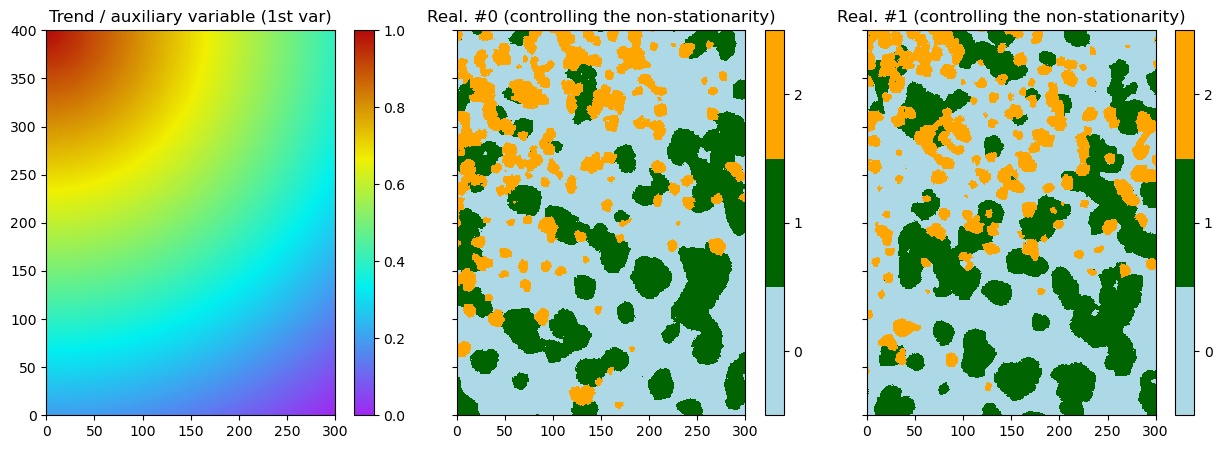

In [13]:
# Retrieve the results
sim = deesse_output['sim'] # list of realization (image), each with one variable

# Display
plt.subplots(1, 3, figsize=(15,5), sharex=True, sharey=True) # 1 x 3 sub-plots

plt.subplot(1,3,1)
gn.imgplot.drawImage2D(im_aux, title='Trend / auxiliary variable (1st var)')

for i in range(2):
    plt.subplot(1, 3, i+2) # select next sub-plot
    gn.imgplot.drawImage2D(sim[i], categ=True, categCol=col,
                           title=f'Real. #{i} (controlling the non-stationarity)')

plt.show()

### Adding conditioning data for the original variable
Of course, some hard data can be handled for the original (categorical) variable.

Define some hard data (point set).

In [14]:
npt = 5 # number of points
nv = 4  # number of variables including x, y, z coordinates
varname = ['x', 'y', 'z', 'code'] # list of variable names
v = np.array([
    [  10.5,   10.5, 0.5, 0], # x, y, z, code: 1st point
    [ 100.5,   20.5, 0.5, 1], # ...
    [  60.5,  200.5, 0.5, 2],
    [ 120.5,  260.5, 0.5, 2],
    [ 276.5,  354.5, 0.5, 1]
    ]).T # variable values: (nv, npt)-array
hd = gn.img.PointSet(npt=npt, nv=nv, varname=varname, val=v)

# Set colors for hard data cells (for further plots)
hd_col=[col[int(v)] for v in hd.val[3]]
# Or convert the color to 'rgba' if required
##import matplotlib.colors
##hd_col=[matplotlib.colors.to_rgba(col[int(v)]) for v in hd.val[3]]

### Fill the input structure for deesse and launch deesse

In [15]:
nreal = 20
deesse_input = gn.deesseinterface.DeesseInput(
    nx=nx, ny=ny, nz=nz,
    sx=sx, sy=sy, sz=sz,
    ox=ox, oy=oy, oz=oz,
    nv=2, varname=['aux', 'code'],
    TI=ti,
    dataImage=im_aux,
    dataPointSet=hd,             # hard data for the variable 'code'
    outputVarFlag=[False, True],
    distanceType=['continuous', 'categorical'],
    nneighboringNode=[1, 24],
    distanceThreshold=[.1,.02],
    maxScanFraction=0.15,
    npostProcessingPathMax=1,
    seed=444,
    nrealization=nreal)

# Run deesse
t1 = time.time() # start time
deesse_output = gn.deesseinterface.deesseRun(deesse_input)
t2 = time.time() # end time
print(f'Elapsed time: {t2-t1:.2g} sec')

DeeSse running... [VERSION 3.2 / BUILD NUMBER 20230411 / OpenMP 19 thread(s)]
* checking out license OK.
DeeSse run complete
Elapsed time: 55 sec


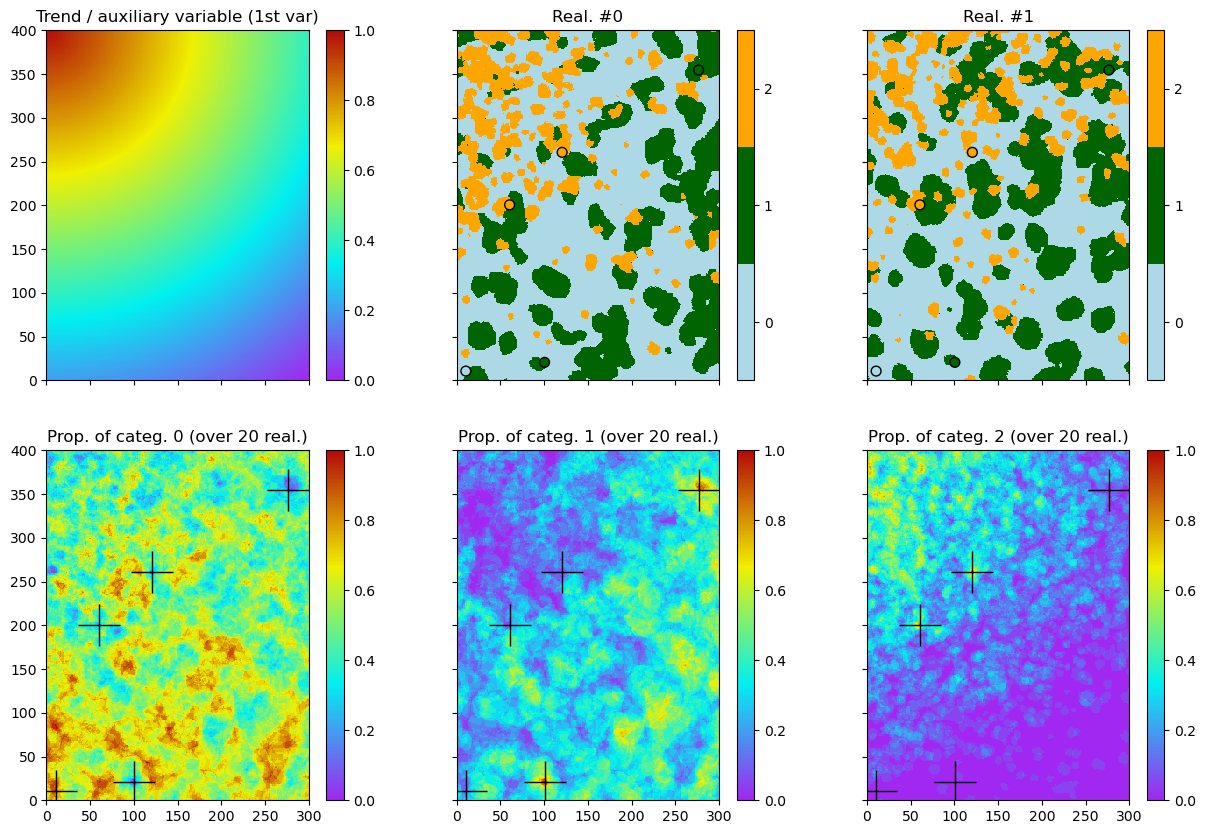

In [16]:
# Retrieve the realizations
sim = deesse_output['sim'] # list of realization (image), each with one variable

# Do some statistics on the realizations
# ... gather all the realizations into one image
all_sim = gn.img.gatherImages(sim) # all_sim is one image with nreal variables
# ... compute the pixel-wise proportion for the given categories
all_sim_stats = gn.img.imageCategProp(all_sim, [0, 1, 2])

# Display
plt.subplots(2,3, figsize=(15,10), sharex=True, sharey=True)
plt.subplot(2,3,1)
gn.imgplot.drawImage2D(im_aux, title='Trend / auxiliary variable (1st var)')

for i in range(2):
    plt.subplot(2, 3, i+2) # select next sub-plot
    gn.imgplot.drawImage2D(sim[i], categ=True, categCol=col, title=f'Real. #{i}')
    plt.scatter(hd.x(), hd.y(), marker='o', s=50, 
                color=hd_col, edgecolors='black', linewidths=1) # add hard data points
for i in range(3):
    plt.subplot(2, 3, i+4) # select next sub-plot
    gn.imgplot.drawImage2D(all_sim_stats, iv=i, title=f'Prop. of categ. {i} (over {nreal} real.)')
    plt.plot(hd.x(), hd.y(), '+', c='black', markersize=30) # add hard data points

plt.show()

### ... using pyramids

In [17]:
# Deesse input
#   - with 2 additional levels (npyramidLevel=2) 
#     and a reduction factor of 2 along x and y axes between the original image 
#     and the 1st pyramid level and between the 1st pyramid level to the second one 
#     (kx=[2, 2], ky=[2, 2], kz=[0, 0]: do not apply reduction along z axis)
pyrGenParams = gn.deesseinterface.PyramidGeneralParameters(npyramidLevel=2, kx=[2, 2], ky=[2, 2], kz=[0, 0])
pyrParams = [gn.deesseinterface.PyramidParameters(nlevel=2, pyramidType='continuous'),
             gn.deesseinterface.PyramidParameters(nlevel=2, pyramidType='categorical_auto')]

nreal = 20
deesse_input = gn.deesseinterface.DeesseInput(
    nx=nx, ny=ny, nz=nz,
    sx=sx, sy=sy, sz=sz,
    ox=ox, oy=oy, oz=oz,
    nv=2, varname=['aux', 'code'],
    TI=ti,
    dataImage=im_aux,
    dataPointSet=hd,
    outputVarFlag=[False, True],
    distanceType=['continuous', 'categorical'],
    nneighboringNode=[1, 24],
    distanceThreshold=[.1,.02],
    maxScanFraction=0.15,
    pyramidGeneralParameters=pyrGenParams, # pyramid general parameters
    pyramidParameters=pyrParams,           # pyramid parameters for each variable
    npostProcessingPathMax=1,
    seed=444,
    nrealization=nreal)

# Run deesse
t1 = time.time() # start time
deesse_output = gn.deesseinterface.deesseRun(deesse_input)
t2 = time.time() # end time
print(f'Elapsed time: {t2-t1:.2g} sec')

DeeSse running... [VERSION 3.2 / BUILD NUMBER 20230411 / OpenMP 19 thread(s)]
* checking out license OK.
DeeSse run complete
Elapsed time: 1.2e+02 sec


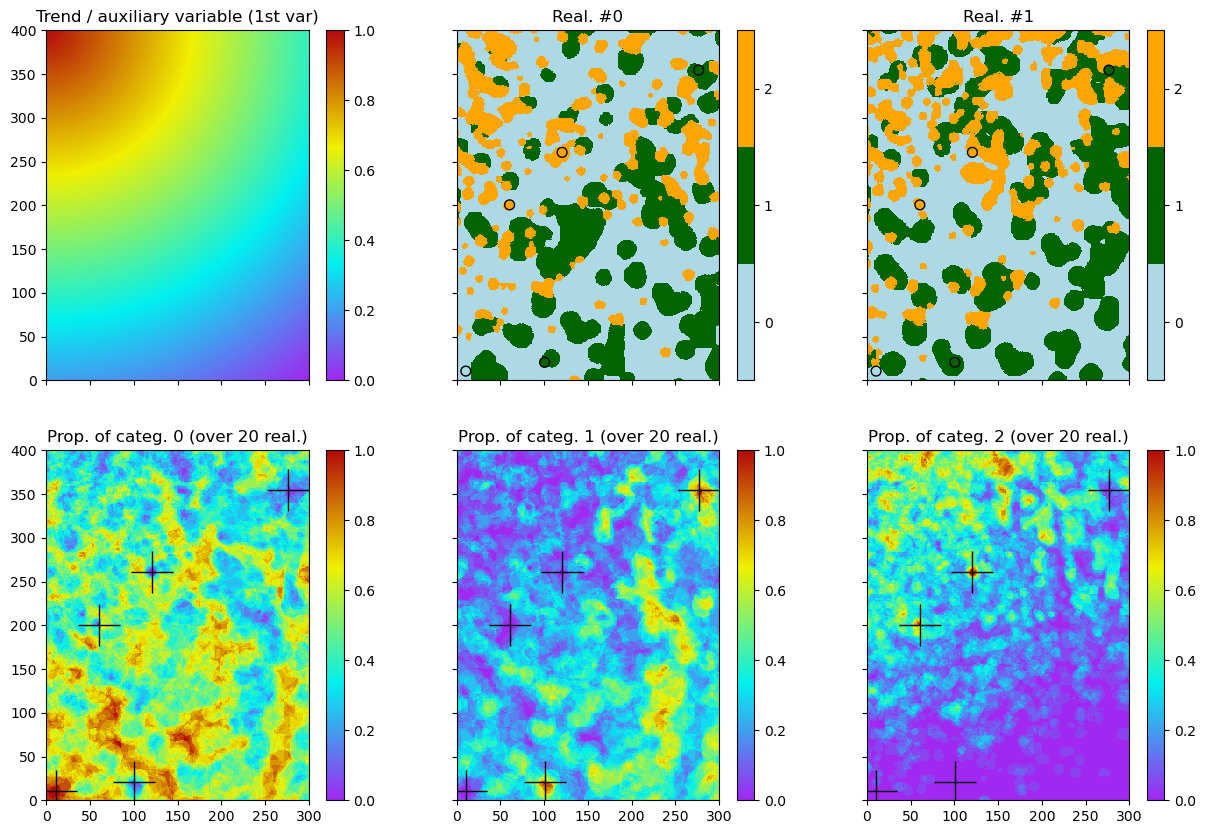

In [18]:
# Retrieve the realizations
sim = deesse_output['sim'] # list of realization (image), each with one variable

# Do some statistics on the realizations
# ... gather all the realizations into one image
all_sim = gn.img.gatherImages(sim) # all_sim is one image with nreal variables
# ... compute the pixel-wise proportion for the given categories
all_sim_stats = gn.img.imageCategProp(all_sim, [0, 1, 2])

# Display
plt.subplots(2,3, figsize=(15,10), sharex=True, sharey=True)
plt.subplot(2,3,1)
gn.imgplot.drawImage2D(im_aux, title='Trend / auxiliary variable (1st var)')

for i in range(2):
    plt.subplot(2, 3, i+2) # select next sub-plot
    gn.imgplot.drawImage2D(sim[i], categ=True, categCol=col, title=f'Real. #{i}')
    plt.scatter(hd.x(), hd.y(), marker='o', s=50, 
                color=hd_col, edgecolors='black', linewidths=1) # add hard data points
for i in range(3):
    plt.subplot(2, 3, i+4) # select next sub-plot
    gn.imgplot.drawImage2D(all_sim_stats, iv=i, title=f'Prop. of categ. {i} (over {nreal} real.)')
    plt.plot(hd.x(), hd.y(), '+', c='black', markersize=30) # add hard data points

plt.show()